<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px;">

## Naive Bayes Language Detection Lab

_Author: David Yerrington (SF) _

In this lab, we will use Naive Bayes (and other classifiers) to auto-detect the language of a given tweet. We will then assess the performance of our classifier.

In [1]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

%matplotlib inline

sns.set_style("darkgrid")

In [3]:
tweets_df = pd.read_csv("../datasets/tweets_language.csv", encoding="utf-8", index_col=0)
tweets_df.index = tweets_df.index.astype(int)    # By default, everything read in is a string!

In [4]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9431 entries, 0 to 9408
Data columns (total 2 columns):
LANG    9409 non-null object
TEXT    9409 non-null object
dtypes: object(2)
memory usage: 221.0+ KB


In [5]:
# Note above that some rows are null, which we cannot use for training
tweets_df = tweets_df.dropna()

In [8]:
len(tweets_df)

9409

In [6]:
tweets_df.head()

,LANG,TEXT
0,en,The #Yolo bailout: Greece's ex-finance chief h...
1,en,Another mental Saturday night. It will be near...
2,en,Sometimes you take bedtime selfies w yer hat s...
3,en,Currently just changed my entire outfit includ...
4,en,I just like listening to @SpotifyAU's top 100 ...


### 1. Data exploration

#### 1.A. Explore a list of tweet words that occur more than 50x
Plot a histogram of some kind might be helpful.

In [9]:
# Let's use the CountVectorizer to count words for us
cvt      =  CountVectorizer(strip_accents='unicode',min_df=51)
X_all    =  cvt.fit_transform(tweets_df['TEXT'])
columns  =  np.array(cvt.get_feature_names())          # ndarray (for indexing below)

# note this is a large sparse matrix. 
#    - rows are tweets, columns are words 
X_all

<9409x229 sparse matrix of type '<type 'numpy.int64'>'
	with 51683 stored elements in Compressed Sparse Row format>

In [10]:
# Converting X_all toarray() may use too much memory (particularly for 32-bit Python!)
print X_all.shape
print "Requires {} ints to do a .toarray()!".format(X_all.shape[0] * X_all.shape[1])

# x_df     =  pd.DataFrame(X_all.toarray(), columns=columns)
# tf_df    =  pd.DataFrame(x_df.sum(), columns=["freq"])
# tf_df.sort_values("freq", ascending=False).head(10)

(9409, 229)
Requires 2154661 ints to do a .toarray()!


In [11]:
# So .. we'll use np.sum() to convert it directly from the sparse matrix!
# This is enormously more memory-efficient ...
#   It only requires one int per column since summing across columns is the total word count.

def get_freq_words(sparse_counts, columns):
    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(X_all.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]

    # pretty-print the results! Remember to always ask whether they make sense ...
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words


freq_words = get_freq_words(X_all, columns)
freq_words[:20]

co        8544
http      6093
https     2658
rt        2222
love      1758
dog       1219
family    1082
france    1032
de         984
us         951
da         889
peace      811
yolo       742
la         723
earth      702
in         604
the        598
planet     589
math       473
en         425
dtype: int64

- Note above that many of the most common words actually may not be relevant to determining language!
- Also, we are removing important features such as capitalization, punctuation, sentence length, etc. that might be important for determining language.

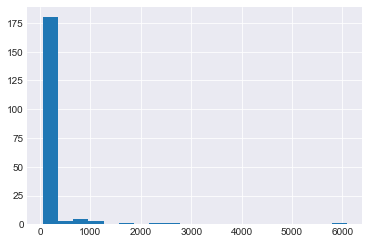

In [16]:
freq_words.hist(bins=20)

#### 1.B. Investigate histogram of counts

http      6093
https     2658
rt        2222
love      1758
dog       1219
family    1082
france    1032
da         889
peace      811
yolo       742
dtype: int64


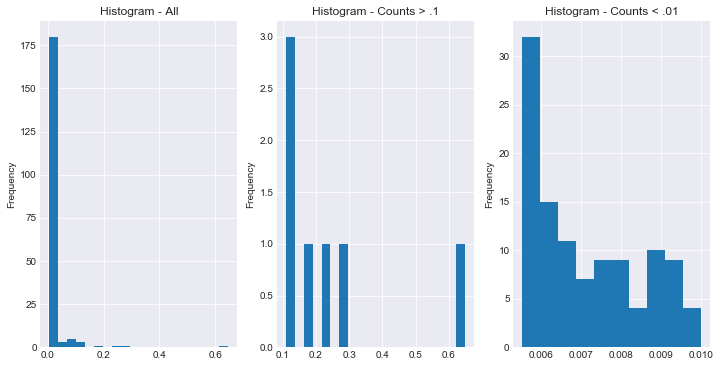

In [19]:
from sklearn.preprocessing import StandardScaler, minmax_scale

def hist_counts(word_counts):
    hist_counts = pd.Series(word_counts/len(tweets_df), 
                            index=word_counts.index)
    
    # Overall graph is hard to understand, so let's break it into three graphs
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
    
    hist_counts.plot(kind="hist", bins=20, ax=axes[0], title="Histogram - All")
    
    # look at the range of extreme commons that seem to exist below .01
    hist_counts[hist_counts < .01].plot(kind="hist", ax=axes[2], title="Histogram - Counts < .01")
    
    # There are a lot of really common tokens within 10% -- filter them out
    hist_counts[hist_counts > .1].plot(kind="hist", bins=20, ax=axes[1], title="Histogram - Counts > .1")

print(freq_words[:10])
hist_counts(freq_words)

#### 1.C. Try it again with stopword removal 

http      6093
https     2658
rt        2222
love      1758
dog       1219
family    1082
france    1032
da         889
peace      811
yolo       742
dtype: int64


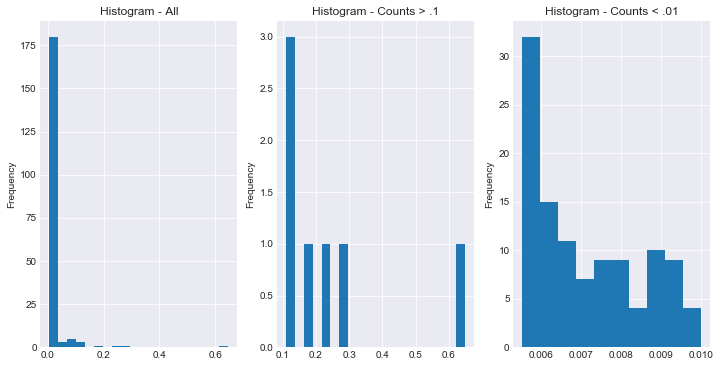

In [20]:
cvt      =  CountVectorizer(strip_accents='unicode', stop_words="english", min_df=51)
X_all    =  cvt.fit_transform(tweets_df['TEXT'])
columns  =  np.array(cvt.get_feature_names())

freq_words = get_freq_words(X_all, columns)

print(freq_words[:10])
hist_counts(freq_words)

In [22]:
# Checking range between .99 - .99999 -- there seem to be lots of words there
freq_words.quantile(.99), freq_words.quantile(.99999)

(2248.1600000000008, 6086.336100000033)

In [23]:
# find the %1, and %10 threshold for masking
freq_words[(freq_words >= 10) & (freq_words <= 150)]

gt                 145
pet                144
di                 143
et                 142
ukraine            139
germany            139
follow             139
al                 138
art                138
anti               135
se                 134
du                 132
nature             132
es                 132
pour               131
para               130
imperialist        129
falseflag          129
des                126
world              119
beautiful          117
fun                117
organic            115
nasa               114
friends            113
mi                 111
puppy              111
sun                111
una                109
si                 108
                  ... 
im                  56
nice                55
animals             55
rocket              55
vida                55
great               55
um                  54
child               54
swag                54
photooftheday       54
night               54
parti               54
injury     

#### 1.D. Explore ngrams between 2 and 4
Display the top 75 ngrams with frequencies.

In [25]:
cvt = CountVectorizer(stop_words="english", ngram_range=(2,4))
X_all = cvt.fit_transform(tweets_df['TEXT'])
columns  =  np.array(cvt.get_feature_names())

freq_words = get_freq_words(X_all, columns)
print(freq_words.shape)
freq_words.head()

(188765,)


naturevalley planet    193
france http            193
da http                173
love https             155
junksilver coins       151
dtype: int64

#### 1.E. (Optional) try expanding the list of stopwords
There are definitely some non-words such as web urls, etc. If you could remove them, this could help us improve the score.  Identify word/tokens that don't add much value to either class.  **You should additionally look at ngrams per language to fine tune your preprocessing.  This has the greatest potential to improve your results without tuning any model parameters.**

Using `nltk.corpus`, we can get a baseline list of stop words.  Try to expand it and pass it to our vectorizer.

In [26]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['http', 'https', 'rt']

In [27]:
# These look pretty clean for a first step in anlaysis
cvt = CountVectorizer(stop_words=stop, lowercase=True, strip_accents="unicode", ngram_range=(1,2))
X_all = cvt.fit_transform(tweets_df['TEXT'])
columns  =  np.array(cvt.get_feature_names())

freq_words = get_freq_words(X_all, columns)
freq_words[:20]

co        8544
love      1758
dog       1219
family    1082
france    1032
de         984
us         951
da         889
peace      811
yolo       742
la         723
earth      702
planet     589
math       473
en         425
hund       333
que        332
vive       307
silver     304
un         304
dtype: int64

### 2. Setup a test / train split of your data using any method you wish.
Try 70/30 to start.

In [28]:
# Find our training size
training_size = int(tweets_df.shape[0] * .7)

# Randomly sample our training data
tweets_train = tweets_df.sample(n=training_size, replace=True)

# Capture the rest of the dataset that's not "training" using an inverse mask (rows NOT IN training dataframe)
mask = tweets_df.index.isin(tweets_train.index)
tweets_test = tweets_df[~mask]

# Should be (2762, 1963) = training / testing = 70/30
tweets_train.shape[0], tweets_test.shape[0]

(6586, 4648)

### 3. Setup a "Pipeline" to vectorize and use MultinomialNB classifier.
Use `lowercase`, `strip_accents`, `Pipeline`, and optionally your updated `stop_words`.  Fit your comment data using the "Insult" feature as your response.

Fit your training data to your pipeline, then score it.

In [29]:
# MultinomialNB
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode', stop_words=stop)),
    ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.7080464716006885

In [30]:
# Alternative -- train on all data
# MultinomialNB
pipeline = Pipeline([
    ('vect', cvt),
    # ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.7360154905335629

#### 3.A. Swap out MultinomialNB with BernoulliNB in the pipeline
How do they compare? Do you have a guess of why BernoulliNB is so poor?

In [33]:
# BernoulliNB
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()), #by adding this we get +2%
    ('cls', BernoulliNB())
]) 
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.4535283993115318

#### 3.B. Also try logistic regression and random forests in the pipeline
How do they compare? Recall that Logistic Regression is discriminative whereas Naive Bayes is generative. Logistic Regression uses optimization to fit a formula that discriminates between the classes, whereas Naive Bayes essentially just computes aggregate statistics. So, Logistic Regression should have a longer training time than Naive Bayes -- does it here? (see `%time`)

Note that Logistic Regression and Random Forests both allow you to see feature "importance"/coefficients. In this case, these coefficients will inform you how strong each word indicates a language. Optionally, see if you can sort these coefficients by their values to get the strongest and weakest indicator words for languages.

In [34]:
# LogisticRegression
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
]) 
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.7220309810671256

In [37]:
from sklearn.ensemble import RandomForestClassifier

# RF - 100
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=100))
]) 
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.6749139414802066

In [38]:
# RF - 200
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=200))
]) 
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.6764199655765921

#### 3.C. Also try tweaking the paramters of CountVectorizer and TfidfTranformer

Remove Tfidf also. Good / bad?

In [35]:
cvt2 = CountVectorizer(stop_words=stop, lowercase=True, strip_accents="unicode", ngram_range=(1,2))
pipeline = Pipeline([
    ('vect', cvt2),
    # ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
]) 
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.7390275387263339

In [39]:
pipeline = Pipeline([
    ('vect', cvt),
    #('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=100))
]) 
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.6949225473321858

#  
#  
#  
### 4. Check your score.
Which languages does your model work best at? Run a classification report for all languages. [Plot AUC/ROC](../../week-04/2.3-evaluating_model_fit/code/AUC-ROC-codealong.ipynb) for particular languages (vs all others) and compare them -- do they show that some languages perform better? Does our model perform worse than guessing on some languages? Also, [review classfication reporting metrics](../../week-04/4.3-advanced-model_evaluation/code/starter-code/week4-4.1-classification-report.ipynb).

In [40]:
pipeline = Pipeline([
    ('vect', cvt),
    # ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.7360154905335629

In [41]:
tweets_test.shape, len(predicted)

((4648, 2), 4648)

In [42]:
predicted = pipeline.predict(tweets_test["TEXT"])
print classification_report(tweets_test["LANG"], predicted)

             precision    recall  f1-score   support

         de       0.80      0.76      0.78       546
         en       0.65      0.80      0.72       714
         es       0.65      0.84      0.74       572
         fr       0.84      0.85      0.84       564
         it       0.75      0.71      0.73       439
         pt       0.72      0.76      0.74       519
         ru       0.78      0.81      0.80       368
         sv       0.81      0.72      0.76       325
         tl       0.00      0.00      0.00         1
         uk       0.86      0.19      0.31       100
        und       0.71      0.49      0.58       295
         zh       0.94      0.36      0.52       205

avg / total       0.75      0.74      0.73      4648



/Users/edoardo/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
def multi_roc(y, probs):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        # probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [44]:
from sklearn.metrics import roc_curve

def plot_roc(y, probs, threshmarkers=None):
    fpr, tpr, thresh = roc_curve(y, probs)

    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, lw=2)
   
    plt.xlabel("False Positive Rate\n(1 - Specificity)")
    plt.ylabel("True Positive Rate\n(Sensitivity)")
    plt.xlim([-0.025, 1.025])
    plt.ylim([-0.025, 1.025])
    plt.xticks(np.linspace(0, 1, 21), rotation=45)
    plt.yticks(np.linspace(0, 1, 21))
    plt.show()

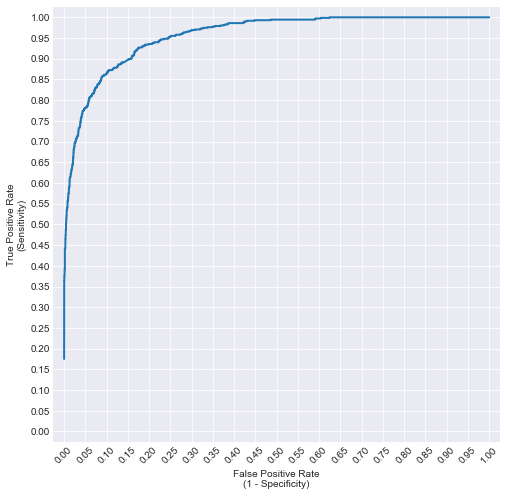

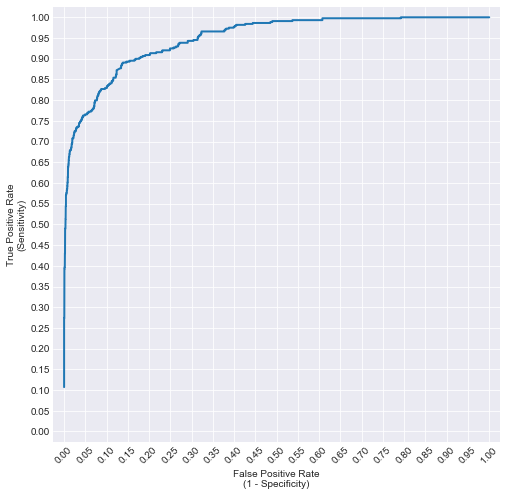

In [45]:
predicted_proba = pipeline.predict_proba(tweets_test['TEXT'])
plot_roc(tweets_test['LANG'].apply(lambda x: x == "en"), predicted_proba[:, list(pipeline.classes_).index("en")])
plot_roc(tweets_test['LANG'].apply(lambda x: x == "it"), predicted_proba[:, list(pipeline.classes_).index("it")])

### 5 Check out your baseline.

What is the chance that you will randomly guess correctly without any modeling? Assume the language of your input phrase has the same chance of appearing as the languages in your training set.

In [46]:
(tweets_train.LANG.value_counts() / len(tweets_train)).mean()

0.08333333333333333

### 6. What is your model not getting right?

Check out the incorrectly classified tweets.  Any noticable patterns? Can you explain why many of these are incorrectly classified, given what you know about how Naive Bayes works?  Pay particular attention to the recall metric.  What might be done in preprocessing steps to improve accuracy?  

- Try to improve with your **preprocessing first**
- THEN try to tweak your **parameters to your model(s)**

In [47]:
predicted = pipeline.predict(tweets_df["TEXT"])

# Incorrectly classified
incorrect_preds = tweets_df[(predicted != tweets_df['LANG'])]

incorrect_df = pd.DataFrame({'actual': incorrect_preds['LANG'], 
                             'predicted': predicted[incorrect_preds.index],
                             'TEXT': incorrect_preds['TEXT']})

incorrect_df

,TEXT,actual,predicted
3,Currently just changed my entire outfit includ...,en,sv
24,Just tweeting while beating @tompritchett52 at...,en,es
32,RT @RLump95: Man it's to hot outside to not go...,en,sv
36,"Do I look ""swaggin"" and cool yet??? #Deadpool ...",en,es
49,00:16 Breaking the system #YOLO,en,und
51,I just sent a cold e-mail with Bubbs checking ...,en,es
63,LOOK @GRAB_1558_FOLLOWS\n\n#dubai #best #wcw #...,en,de
76,Before and after. #haircut #menscut #mensfashi...,en,de
87,Welcome to the #jungle #l4l #f4f #like4like #n...,en,pt
90,#Windows10 is almost here #YOLO,en,es


## Additional Practice
In the datasets directory are two additional datasets you can use for additional pratice:

- **/datasets/tweets_sentiment.csv** - Sentiment analysis

- **/datasets/insults_train.csv** - [Kaggle dataset](https://www.kaggle.com/c/detecting-insults-in-social-commentary). _WARNING:_ This content is fairly provacative and contains very offensive and insensitive words. However, this type of problem is very common in the continuum of comment threads throughout the web.

    - Check [this blog post](http://webmining.olariu.org/my-first-kaggle-competition-and-how-i-ranked/) by a guy who used SVM, a "neural network", a ton of cleaning, then placed 3rd in a Kaggle competition featuing this same dataset. Also see [this blog post](http://peekaboo-vision.blogspot.de/2012/09/recap-of-my-first-kaggle-competition.html) -- he got 6th place and found the best model was a simple Logistic Regression!

#### Where Next?

If you're interested in this type of problem, a great area to read up on is sentiment analysis.  This [Kaggle dataset](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) is an excellent opportunity to practice more.  Also these whitepapers are great places to expand on this topic:

- [Fast and accurate sentiment classification using an
enhanced Naive Bayes model](http://arxiv.org/pdf/1305.6143.pdf) *Great overview!*
- [Sarcasm Detection](http://www.aclweb.org/anthology/P15-2124)
- [Making Computers Laugh:
Investigations in Automatic Humor Recognition](http://www.aclweb.org/anthology/H05-1067)
- [Modelling Sarcasm in Twitter, a Novel Approach](http://www.aclweb.org/anthology/W14-2609)
- [RUNNING HEAD: NARCISSISM AND LIE DETECTION](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/107345/zarins.finalthesis.pdf?sequence=1) *The study metrics are interesting*